# Modeling - SARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import seaborn as sns
import os 

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

In [2]:
df_train = pd.read_pickle(parent_dir + r"\data\processed\feature_engineering_train_dataset.pkl")
df_valid = pd.read_pickle(parent_dir + r"\data\processed\feature_engineering_validation_dataset.pkl")

## CO(GT)

In [3]:
feature_cols = 'COGT'
y_train = np.log(df_train.set_index('date_time')[feature_cols])
y_valid = df_valid.set_index('date_time')[feature_cols]

In [4]:
from statsmodels.tsa.stattools import adfuller
 
adfuller_test = adfuller(y_train, autolag = 'AIC', regression='c')

print('ADF Statistic:', adfuller_test[0])
print('p-value:', adfuller_test[1])
print('Used lags:', adfuller_test[2])
print('Number of observations:', adfuller_test[3])

if adfuller_test[1] < 0.05:
    print("This series is stationary.")
else : print("This series is unit root.")
# d = 0

ADF Statistic: -6.822782193353685
p-value: 1.982365984740464e-09
Used lags: 32
Number of observations: 5583
This series is stationary.


In [5]:
seasonal_diff = y_train.diff(24).dropna()
adfuller_test = adfuller(seasonal_diff, autolag = 'AIC', regression='c')

print('ADF Statistic:', adfuller_test[0])
print('p-value:', adfuller_test[1])
print('Used lags:', adfuller_test[2])
print('Number of observations:', adfuller_test[3])

if adfuller_test[1] < 0.05:
    print("This series is stationary.")
else : print("This series is unit root.")
# seasonal d = 0

ADF Statistic: -12.054188033375487
p-value: 2.556074690562521e-22
Used lags: 29
Number of observations: 5562
This series is stationary.


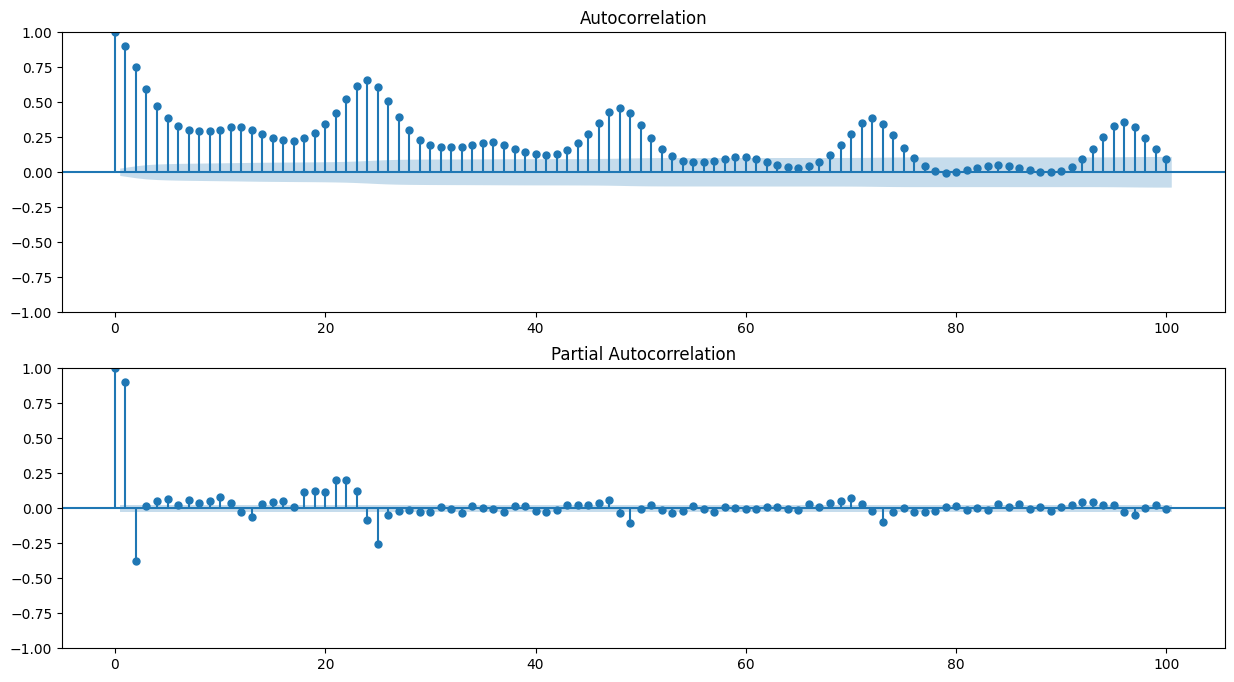

In [6]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(y_train, lags=100, ax=ax[0], alpha = 0.05)
fig = plot_pacf(y_train, lags=100, ax=ax[1], alpha = 0.05)
plt.show()

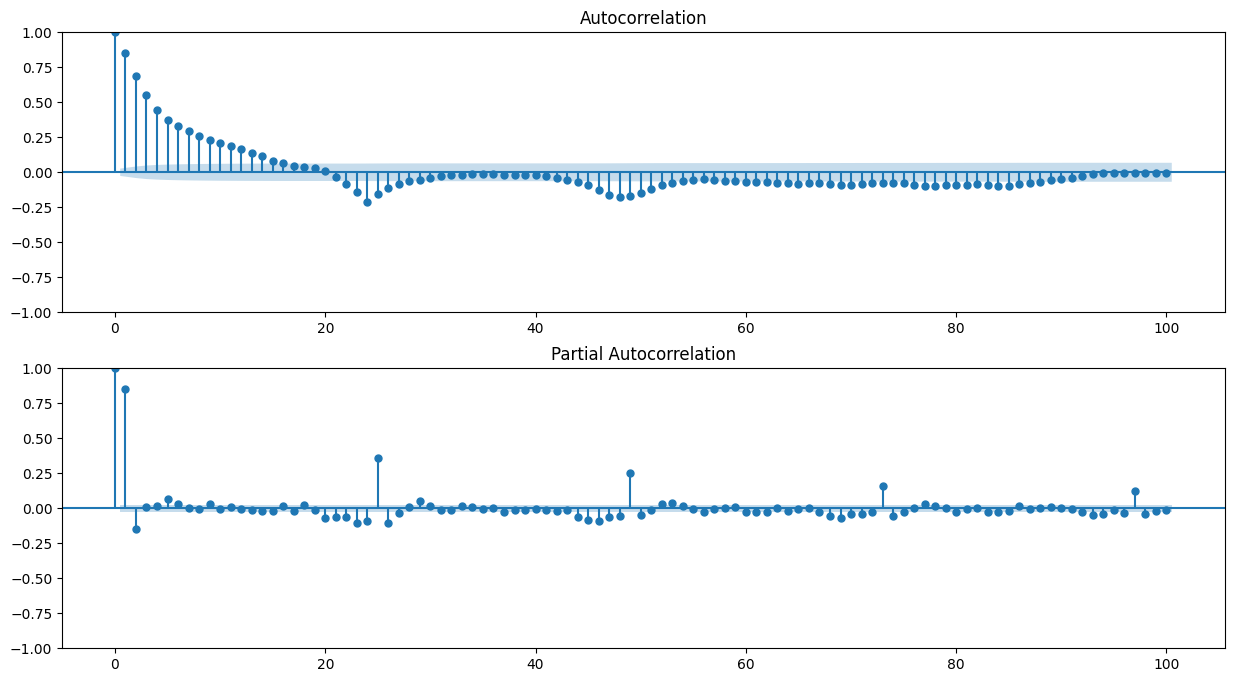

In [7]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(seasonal_diff.dropna(), lags=100, ax=ax[0], alpha = 0.05)
fig = plot_pacf(seasonal_diff.dropna(), lags=100, ax=ax[1], alpha = 0.05)
plt.show()

In [8]:
p = 3   # PACF cuts off at lag 3
d = 0   # Stationary
q = 4   # ACF cuts off at lag 4
P = 1   # Seasonal PACF spike at lag 24
D = 1   # Seasonality is very strong
Q = 0   # ACF has sinusoidal pattern
S = 24  # 24 hours in a day (hourly data)

In [9]:
model = sm.tsa.statespace.SARIMAX(y_train,order=(p,d,q),freq='H',seasonal_order=(P,D,Q,S),enforce_stationarity=False, enforce_invertibility=False,).fit()
model.summary()

c:\FinalProjectEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:595: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = to_offset(freq)
c:\FinalProjectEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\FinalProjectEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                COGT   No. Observations:                 5616
Model:             SARIMAX(3, 0, 4)x(1, 1, [], 24)   Log Likelihood               -1134.996
Date:                             Fri, 11 Apr 2025   AIC                           2287.991
Time:                                     17:25:54   BIC                           2347.609
Sample:                                 03-12-2004   HQIC                          2308.773
                                      - 10-31-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5032      0.163      9.224      0.000       1.184       1.823
ar.L2         -0.6192      0.275     -2.249      0.025      -1.159      -0.080
ar.L3          0.0791      0.120      0.658      0.510      -0.156       0.315
ma.L1         -0.4786      0.163     -2.944      0.003      -0.797      -0.160
ma.L2         -0.0341      0.118     -0.288      0.773      -0.266       0.198
ma.L3         -0.0592      0.028     -2.135      0.033      -0.113      -0.005
ma.L4         -0.0947      0.020     -4.718      0.000      -0.134      -0.055
ar.S.L24      -0.4144      0.009    -45.402      0.000      -0.432      -0.397
sigma2         0.0880      0.001     84.368      0.000       0.086       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2582.16
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

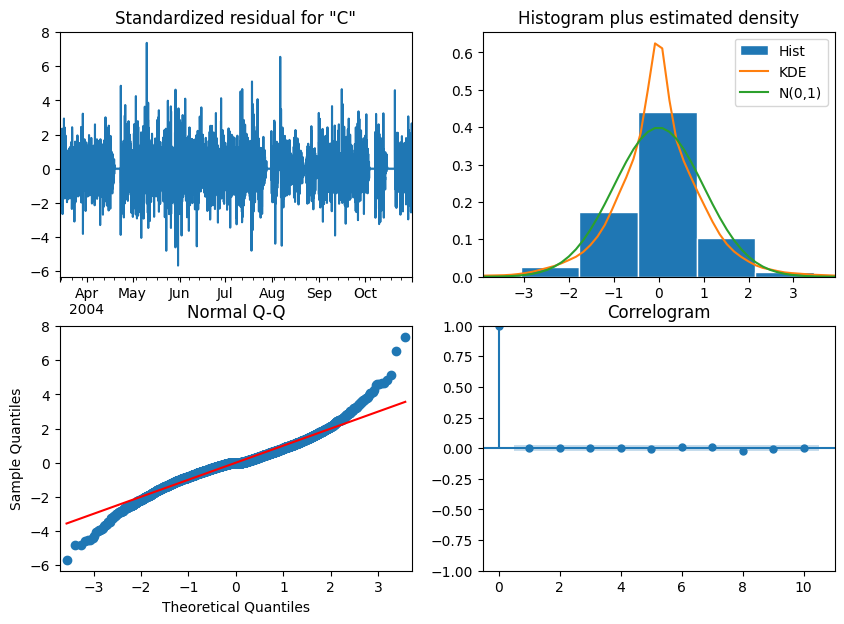

In [10]:
fig = model.plot_diagnostics(figsize=(10, 7))
plt.show()

In [11]:
train_pred = model.predict(start=y_train.index[0], end=y_train.index[-1])
train_pred = np.exp(train_pred)
mae_train = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

print("Train MAE    :", round(mae_train,4))
print("Train RMSE   :", round(rmse_train,4))

Train MAE    : 1.5355
Train RMSE   : 1.7775


In [12]:
y_pred = model.predict(start=y_valid.index[0], end=y_valid.index[-1])
y_pred = np.exp(y_pred)
mae_validation = mean_absolute_error(y_valid, y_pred)
rmse_validation = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Validation MAE   :", round(mae_validation,4))
print("Validation RMSE  :", round(rmse_validation,4))

Validation MAE   : 1.2389
Validation RMSE  : 1.7132


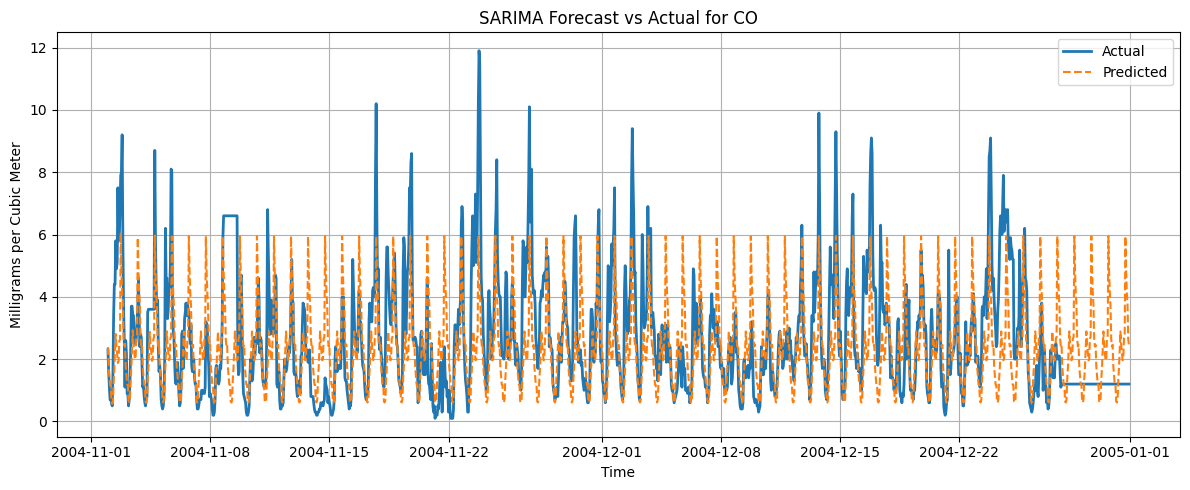

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(y_valid.index, y_valid, label='Actual', linewidth=2)
plt.plot(y_valid.index, y_pred, label='Predicted', linestyle='--')
plt.title('SARIMA Forecast vs Actual for CO')
plt.xlabel('Time')
plt.ylabel('Milligrams per Cubic Meter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## C6H6(GT)

In [14]:
feature_cols = 'C6H6GT'
y_train = np.log(df_train.set_index('date_time')[feature_cols])
y_valid = df_valid.set_index('date_time')[feature_cols]

In [15]:
from statsmodels.tsa.stattools import adfuller
 
adfuller_test = adfuller(y_train, autolag = 'AIC', regression='c')

print('ADF Statistic:', adfuller_test[0])
print('p-value:', adfuller_test[1])
print('Used lags:', adfuller_test[2])
print('Number of observations:', adfuller_test[3])

if adfuller_test[1] < 0.05:
    print("This series is stationary.")
else : print("This series is unit root.")
# d = 0

ADF Statistic: -8.670166841137572
p-value: 4.569157568987148e-14
Used lags: 33
Number of observations: 5582
This series is stationary.


In [16]:
seasonal_diff = y_train.diff(24).dropna()
adfuller_test = adfuller(seasonal_diff, autolag = 'AIC', regression='c')

print('ADF Statistic:', adfuller_test[0])
print('p-value:', adfuller_test[1])
print('Used lags:', adfuller_test[2])
print('Number of observations:', adfuller_test[3])

if adfuller_test[1] < 0.05:
    print("This series is stationary.")
else : print("This series is unit root.")
# seasonal d = 0

ADF Statistic: -13.422471633148877
p-value: 4.163602267330695e-25
Used lags: 28
Number of observations: 5563
This series is stationary.


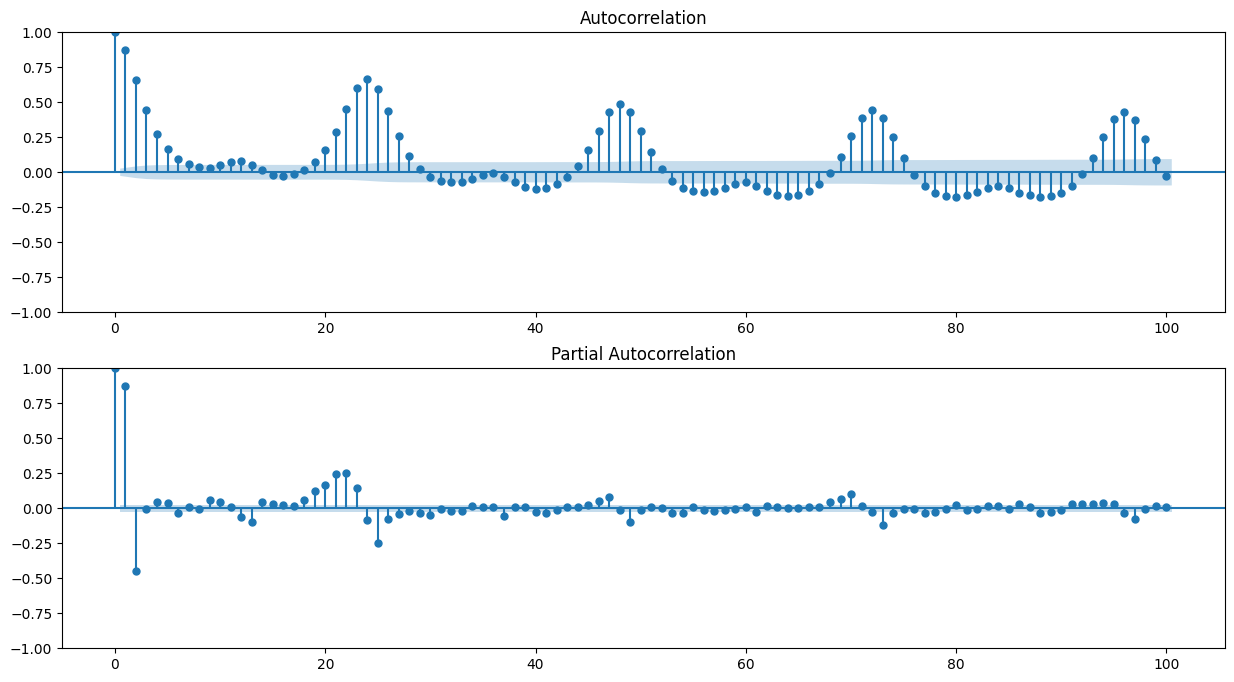

In [17]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(y_train, lags=100, ax=ax[0], alpha = 0.05)
fig = plot_pacf(y_train, lags=100, ax=ax[1], alpha = 0.05)
plt.show()

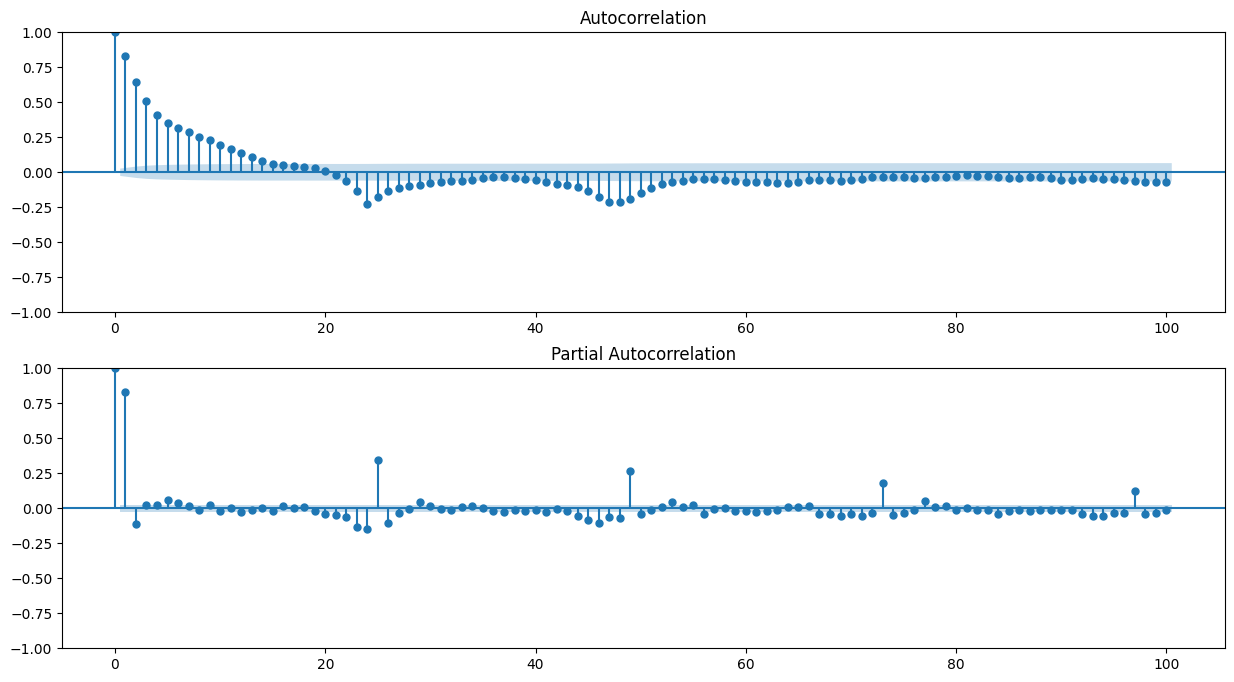

In [18]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(seasonal_diff.dropna(), lags=100, ax=ax[0], alpha = 0.05)
fig = plot_pacf(seasonal_diff.dropna(), lags=100, ax=ax[1], alpha = 0.05)
plt.show()

In [19]:
p = 3   # PACF cuts off at lag 3
d = 0   # Stationary
q = 3   # ACF cuts off at lag 4
P = 1   # Seasonal PACF spike at lag 24
D = 1   # Seasonality is very strong
Q = 0   # ACF has sinusoidal pattern
S = 24  # 24 hours in a day (hourly data)

In [20]:
model = sm.tsa.statespace.SARIMAX(y_train,order=(p,d,q),freq='H',seasonal_order=(P,D,Q,S),enforce_stationarity=False, enforce_invertibility=False,).fit()
model.summary()

c:\FinalProjectEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:595: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = to_offset(freq)
c:\FinalProjectEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\FinalProjectEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              C6H6GT   No. Observations:                 5616
Model:             SARIMAX(3, 0, 3)x(1, 1, [], 24)   Log Likelihood               -1418.505
Date:                             Fri, 11 Apr 2025   AIC                           2853.010
Time:                                     17:26:19   BIC                           2906.004
Sample:                                 03-12-2004   HQIC                          2871.483
                                      - 10-31-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0072      0.143     14.066      0.000       1.728       2.287
ar.L2         -1.4417      0.241     -5.977      0.000      -1.915      -0.969
ar.L3          0.4000      0.104      3.846      0.000       0.196       0.604
ma.L1         -1.0287      0.143     -7.181      0.000      -1.310      -0.748
ma.L2          0.2847      0.108      2.636      0.008       0.073       0.496
ma.L3         -0.0014      0.032     -0.045      0.964      -0.065       0.062
ar.S.L24      -0.4126      0.011    -38.552      0.000      -0.434      -0.392
sigma2         0.0975      0.001     68.501      0.000       0.095       0.100
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               529.17
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

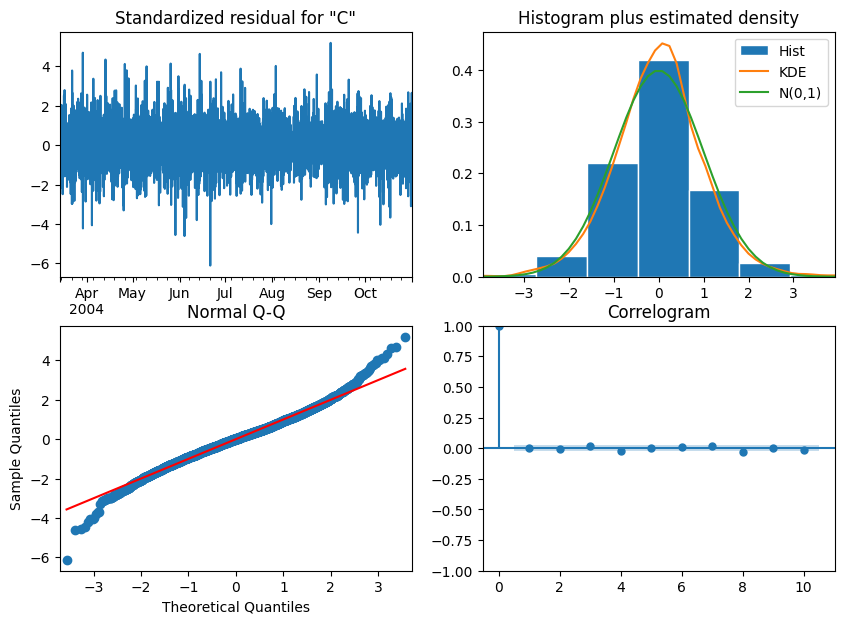

In [21]:
fig = model.plot_diagnostics(figsize=(10, 7))
plt.show()

In [22]:
train_pred = model.predict(start=y_train.index[0], end=y_train.index[-1])
train_pred = np.exp(train_pred)
mae_train = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

print("Train MAE    :", round(mae_train,4))
print("Train RMSE   :", round(rmse_train,4))

Train MAE    : 8.3436
Train RMSE   : 10.7189


In [23]:
y_pred = model.predict(start=y_valid.index[0], end=y_valid.index[-1])
y_pred = np.exp(y_pred)
mae_validation = mean_absolute_error(y_valid, y_pred)
rmse_validation = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Validation MAE   :", round(mae_validation,4))
print("Validation RMSE  :", round(rmse_validation,4))

Validation MAE   : 6.4742
Validation RMSE  : 8.7177


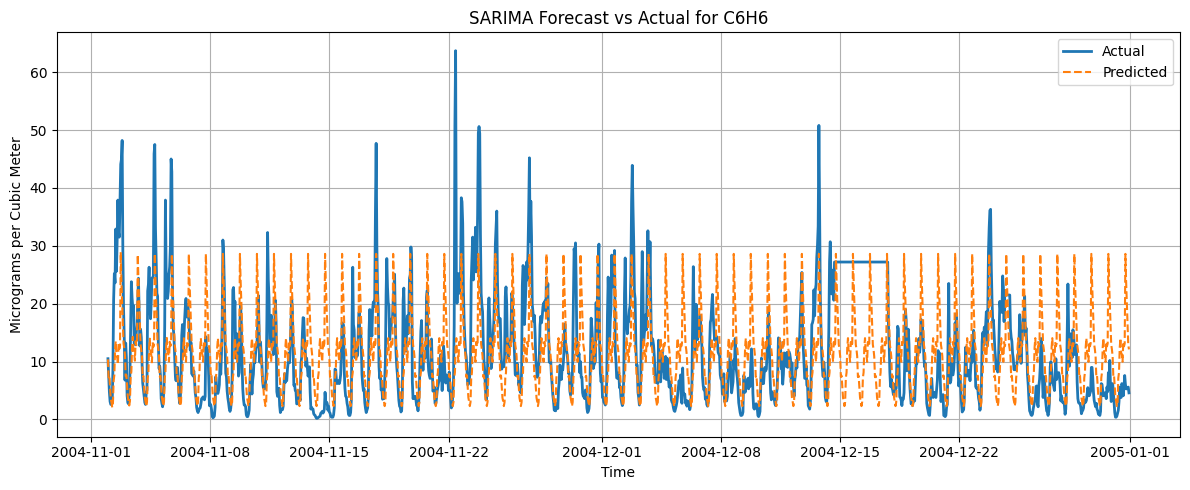

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(y_valid.index, y_valid, label='Actual', linewidth=2)
plt.plot(y_valid.index, y_pred, label='Predicted', linestyle='--')
plt.title('SARIMA Forecast vs Actual for C6H6')
plt.xlabel('Time')
plt.ylabel('Micrograms per Cubic Meter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## NOx(GT)

In [25]:
feature_cols = 'NOxGT'
y_train = np.log(df_train.set_index('date_time')[feature_cols])
y_valid = df_valid.set_index('date_time')[feature_cols]

In [26]:
from statsmodels.tsa.stattools import adfuller
 
adfuller_test = adfuller(y_train, autolag = 'AIC', regression='c')

print('ADF Statistic:', adfuller_test[0])
print('p-value:', adfuller_test[1])
print('Used lags:', adfuller_test[2])
print('Number of observations:', adfuller_test[3])

if adfuller_test[1] < 0.05:
    print("This series is stationary.")
else : print("This series is unit root.")
# d = 0

ADF Statistic: -5.212977736063132
p-value: 8.271256965095951e-06
Used lags: 33
Number of observations: 5582
This series is stationary.


In [27]:
seasonal_diff = y_train.diff(24).dropna()
adfuller_test = adfuller(seasonal_diff, autolag = 'AIC', regression='c')

print('ADF Statistic:', adfuller_test[0])
print('p-value:', adfuller_test[1])
print('Used lags:', adfuller_test[2])
print('Number of observations:', adfuller_test[3])

if adfuller_test[1] < 0.05:
    print("This series is stationary.")
else : print("This series is unit root.")
# seasonal d = 0

ADF Statistic: -12.849312354344818
p-value: 5.3951957688493486e-24
Used lags: 32
Number of observations: 5559
This series is stationary.


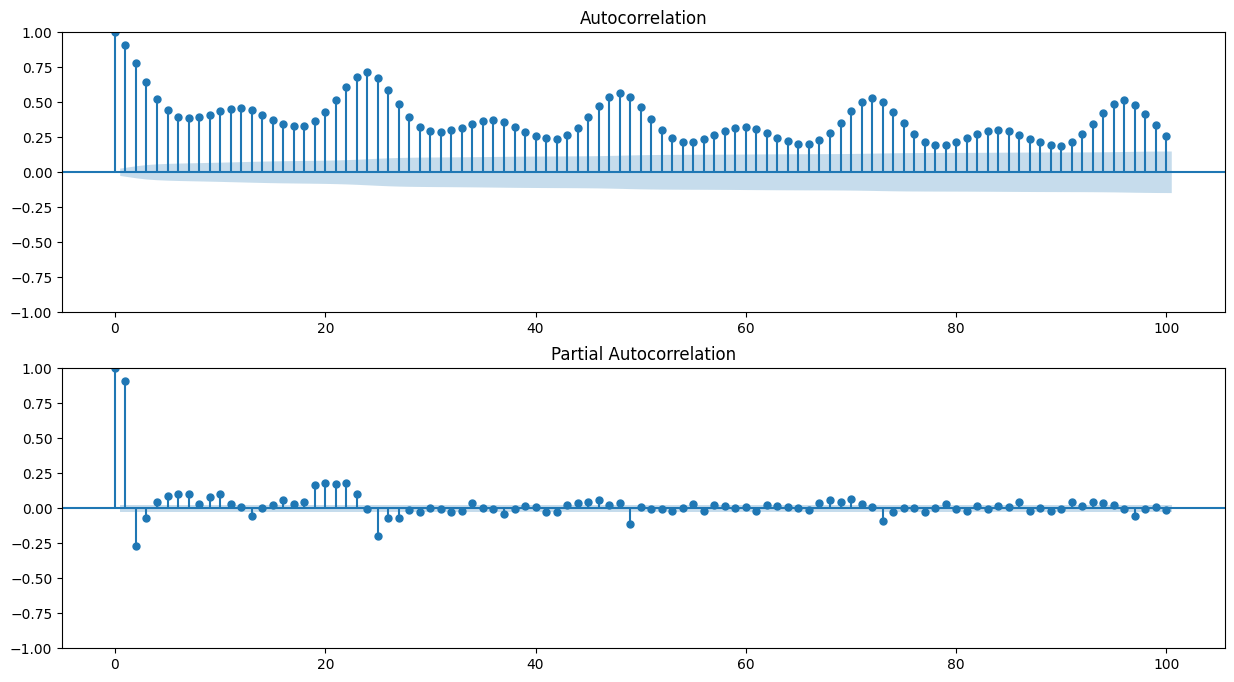

In [28]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(y_train, lags=100, ax=ax[0], alpha = 0.05)
fig = plot_pacf(y_train, lags=100, ax=ax[1], alpha = 0.05)
plt.show()

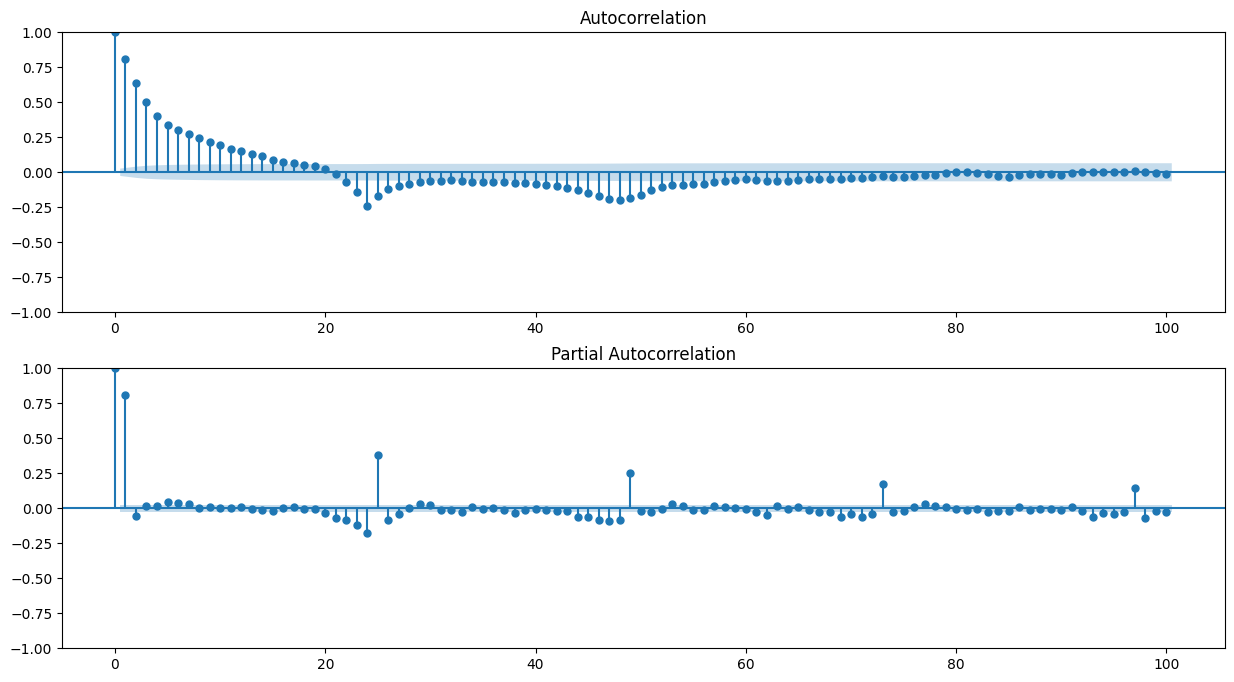

In [29]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(seasonal_diff.dropna(), lags=100, ax=ax[0], alpha = 0.05)
fig = plot_pacf(seasonal_diff.dropna(), lags=100, ax=ax[1], alpha = 0.05)
plt.show()

In [30]:
p = 2   # PACF cuts off at lag 2
d = 0   # Stationary
q = 2   # ACF cuts off at lag 2
P = 1   # Seasonal PACF spike at lag 24
D = 1   # Seasonality is very strong
Q = 0   # ACF has sinusoidal pattern
S = 24  # 24 hours in a day (hourly data)

In [31]:
model = sm.tsa.statespace.SARIMAX(y_train,order=(p,d,q),freq='H',seasonal_order=(P,D,Q,S),enforce_stationarity=False, enforce_invertibility=False,).fit()
model.summary()

c:\FinalProjectEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:595: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = to_offset(freq)
c:\FinalProjectEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               NOxGT   No. Observations:                 5616
Model:             SARIMAX(2, 0, 2)x(1, 1, [], 24)   Log Likelihood               -1685.281
Date:                             Fri, 11 Apr 2025   AIC                           3382.561
Time:                                     17:26:29   BIC                           3422.308
Sample:                                 03-12-2004   HQIC                          3396.416
                                      - 10-31-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1843      1.368      0.866      0.387      -1.496       3.865
ar.L2         -0.2970      1.120     -0.265      0.791      -2.492       1.898
ma.L1         -2.4929      8.931     -0.279      0.780     -19.997      15.012
ma.L2         -0.3072      1.191     -0.258      0.796      -2.641       2.027
ar.S.L24      -0.4437      0.007    -60.202      0.000      -0.458      -0.429
sigma2         0.0157      0.108      0.145      0.884      -0.197       0.228
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5351.07
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

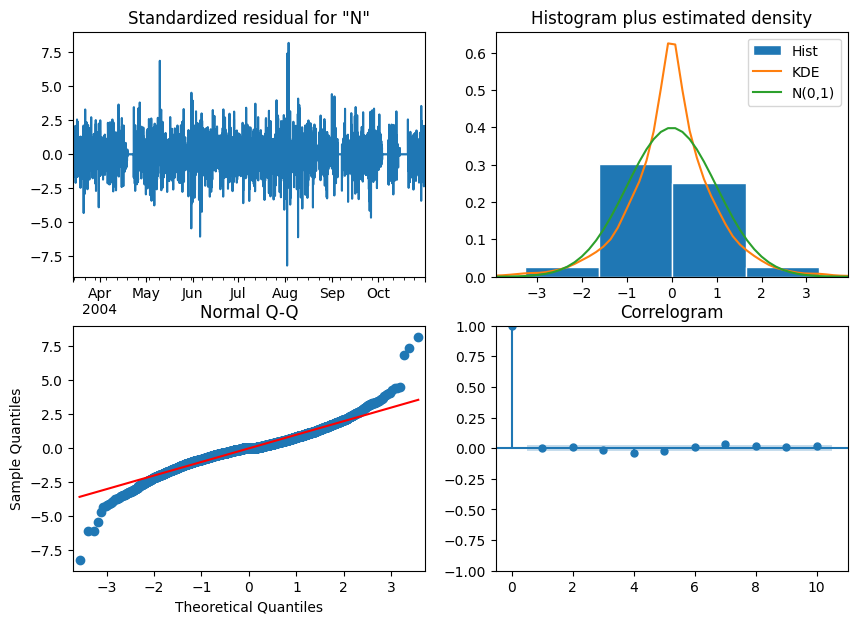

In [32]:
fig = model.plot_diagnostics(figsize=(10, 7))
plt.show()

In [33]:
train_pred = model.predict(start=y_train.index[0], end=y_train.index[-1])
train_pred = np.exp(train_pred)
mae_train = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

print("Train MAE    :", round(mae_train,4))
print("Train RMSE   :", round(rmse_train,4))

Train MAE    : 162.1481
Train RMSE   : 216.9671


In [34]:
y_pred = model.predict(start=y_valid.index[0], end=y_valid.index[-1])
y_pred = np.exp(y_pred)
mae_validation = mean_absolute_error(y_valid, y_pred)
rmse_validation = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Validation MAE   :", round(mae_validation,4))
print("Validation RMSE  :", round(rmse_validation,4))

Validation MAE   : 200.9185
Validation RMSE  : 279.8889


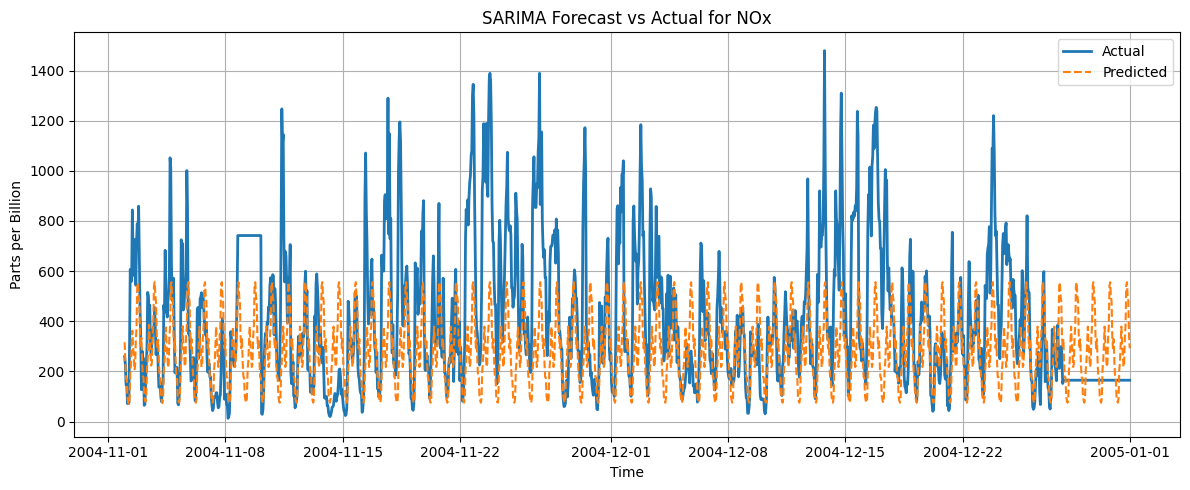

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(y_valid.index, y_valid, label='Actual', linewidth=2)
plt.plot(y_valid.index, y_pred, label='Predicted', linestyle='--')
plt.title('SARIMA Forecast vs Actual for NOx')
plt.xlabel('Time')
plt.ylabel('Parts per Billion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## NO2(GT)

In [36]:
feature_cols = 'NO2GT'
y_train = np.log(df_train.set_index('date_time')[feature_cols])
y_valid = df_valid.set_index('date_time')[feature_cols]

In [37]:
from statsmodels.tsa.stattools import adfuller
 
adfuller_test = adfuller(y_train, autolag = 'AIC', regression='c')

print('ADF Statistic:', adfuller_test[0])
print('p-value:', adfuller_test[1])
print('Used lags:', adfuller_test[2])
print('Number of observations:', adfuller_test[3])

if adfuller_test[1] < 0.05:
    print("This series is stationary.")
else : print("This series is unit root.")
# d = 0

ADF Statistic: -8.696611207281322
p-value: 3.909475495057954e-14
Used lags: 28
Number of observations: 5587
This series is stationary.


In [38]:
seasonal_diff = y_train.diff(24).dropna()
adfuller_test = adfuller(seasonal_diff, autolag = 'AIC', regression='c')

print('ADF Statistic:', adfuller_test[0])
print('p-value:', adfuller_test[1])
print('Used lags:', adfuller_test[2])
print('Number of observations:', adfuller_test[3])

if adfuller_test[1] < 0.05:
    print("This series is stationary.")
else : print("This series is unit root.")
# seasonal d = 0

ADF Statistic: -13.141167766705339
p-value: 1.4284118643977439e-24
Used lags: 32
Number of observations: 5559
This series is stationary.


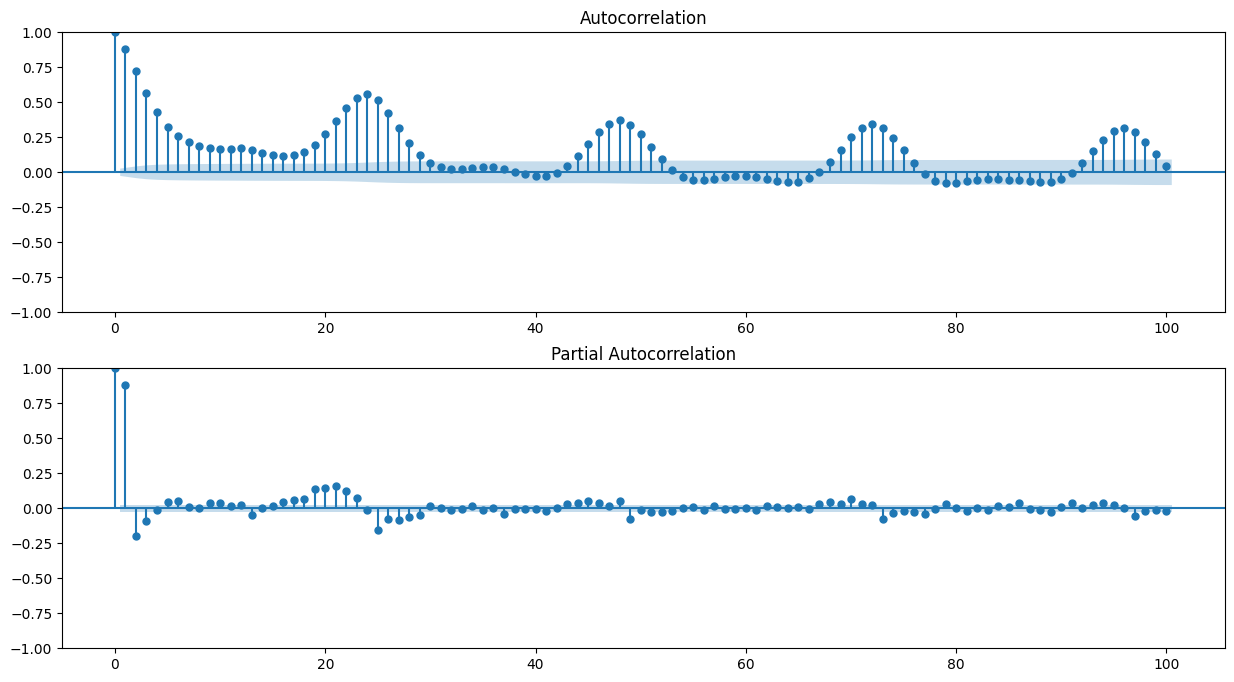

In [39]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(y_train, lags=100, ax=ax[0], alpha = 0.05)
fig = plot_pacf(y_train, lags=100, ax=ax[1], alpha = 0.05)
plt.show()

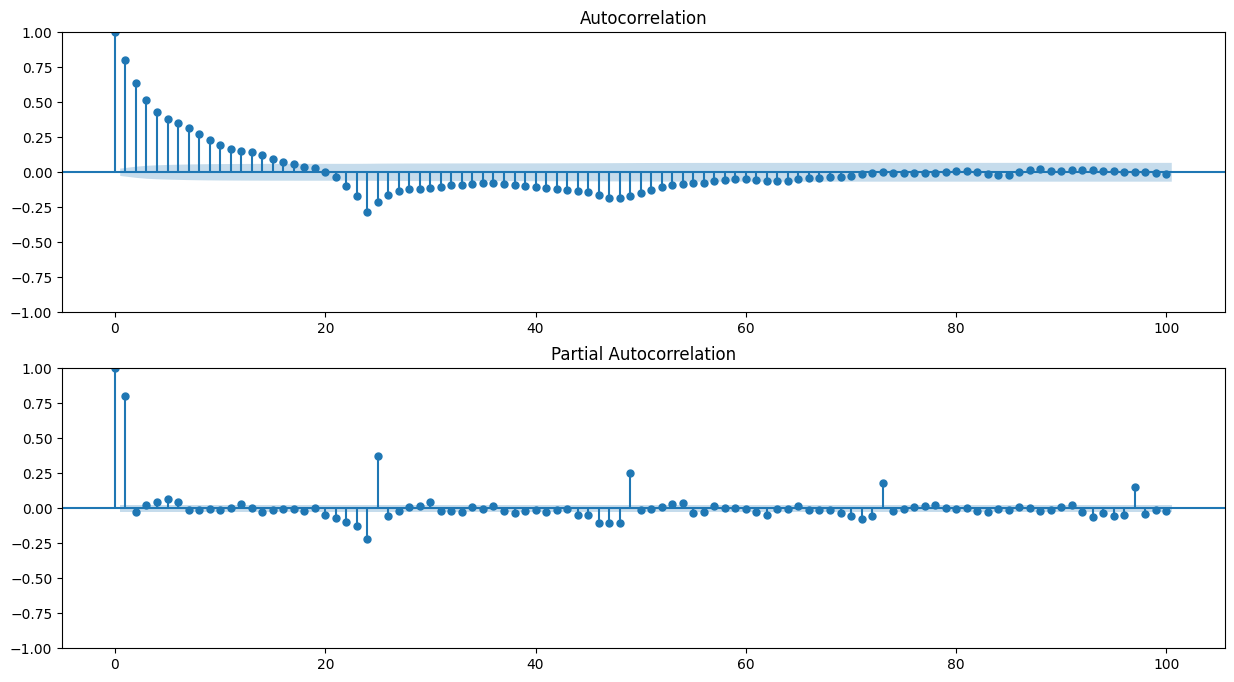

In [40]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(seasonal_diff.dropna(), lags=100, ax=ax[0], alpha = 0.05)
fig = plot_pacf(seasonal_diff.dropna(), lags=100, ax=ax[1], alpha = 0.05)
plt.show()

In [41]:
p = 2   # PACF cuts off at lag 2
d = 0   # Stationary
q = 4   # ACF cuts off at lag 4
P = 1   # Seasonal PACF spike at lag 24
D = 1   # Seasonality is very strong
Q = 0   # ACF has sinusoidal pattern
S = 24  # 24 hours in a day (hourly data)

In [42]:
model = sm.tsa.statespace.SARIMAX(y_train,order=(p,d,q),freq='H',seasonal_order=(P,D,Q,S),enforce_stationarity=False, enforce_invertibility=False,).fit()
model.summary()

c:\FinalProjectEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:595: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = to_offset(freq)
c:\FinalProjectEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               NO2GT   No. Observations:                 5616
Model:             SARIMAX(2, 0, 4)x(1, 1, [], 24)   Log Likelihood                 487.839
Date:                             Fri, 11 Apr 2025   AIC                           -959.678
Time:                                     17:26:42   BIC                           -906.682
Sample:                                 03-12-2004   HQIC                          -941.204
                                      - 10-31-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1954      0.112     10.690      0.000       0.976       1.415
ar.L2         -0.2547      0.099     -2.568      0.010      -0.449      -0.060
ma.L1         -0.3258      0.112     -2.920      0.003      -0.544      -0.107
ma.L2         -0.0885      0.011     -8.379      0.000      -0.109      -0.068
ma.L3         -0.0738      0.014     -5.433      0.000      -0.100      -0.047
ma.L4         -0.0632      0.015     -4.174      0.000      -0.093      -0.034
ar.S.L24      -0.4551      0.005    -88.260      0.000      -0.465      -0.445
sigma2         0.0491      0.000    141.962      0.000       0.048       0.050
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             43029.30
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

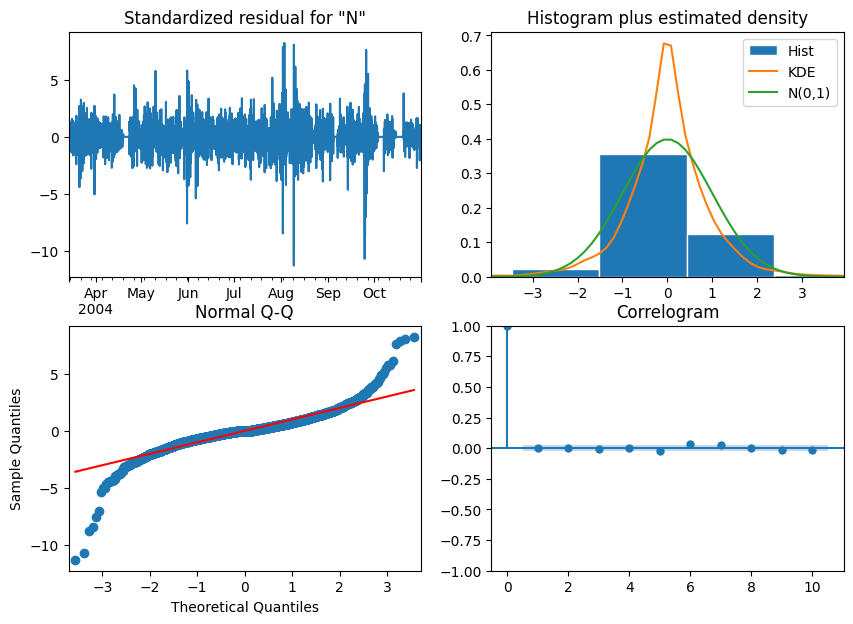

In [43]:
fig = model.plot_diagnostics(figsize=(10, 7))
plt.show()

In [44]:
train_pred = model.predict(start=y_train.index[0], end=y_train.index[-1])
train_pred = np.exp(train_pred)
mae_train = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

print("Train MAE    :", round(mae_train,4))
print("Train RMSE   :", round(rmse_train,4))

Train MAE    : 88.6712
Train RMSE   : 100.2137


In [45]:
y_pred = model.predict(start=y_valid.index[0], end=y_valid.index[-1])
y_pred = np.exp(y_pred)
mae_validation = mean_absolute_error(y_valid, y_pred)
rmse_validation = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Validation MAE   :", round(mae_validation,4))
print("Validation RMSE  :", round(rmse_validation,4))

Validation MAE   : 52.3784
Validation RMSE  : 64.6502


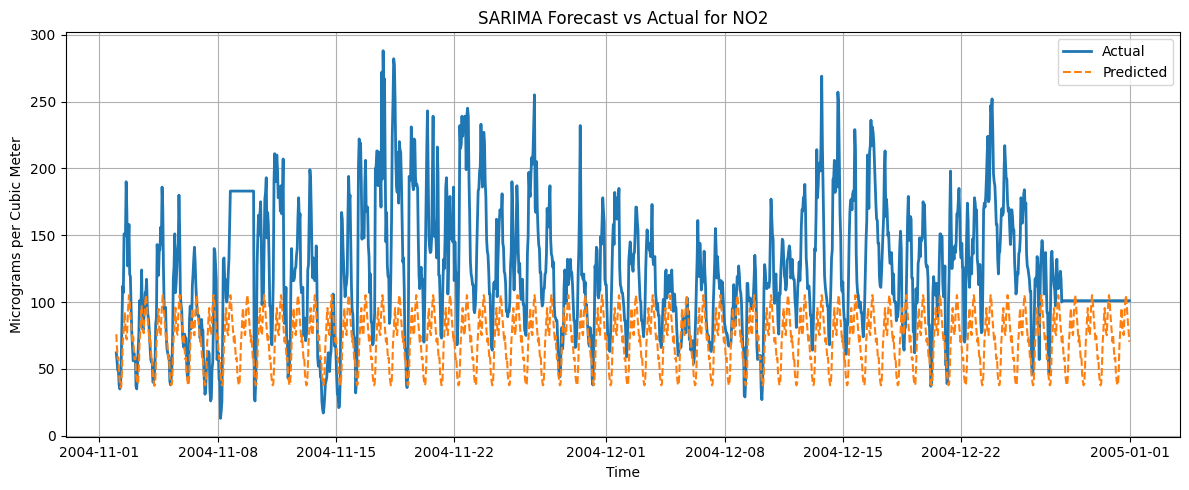

In [46]:
plt.figure(figsize=(12, 5))
plt.plot(y_valid.index, y_valid, label='Actual', linewidth=2)
plt.plot(y_valid.index, y_pred, label='Predicted', linestyle='--')
plt.title('SARIMA Forecast vs Actual for NO2')
plt.xlabel('Time')
plt.ylabel('Micrograms per Cubic Meter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()